* Assignment Name: Term Project 2: Milestone 3
* Due Date: 11/9/2025
* Student Name: Billie Adkins
* DSC 680 - Applied Data Science - T301 2261 Fall Term


References:

https://huggingface.co/datasets/AIxBlock/92k-real-world-call-center-scripts-english

OpenAI. (2025). ChatGPT (October 25 version) [Large language model]. https://chat.openai.com/

Folders containing JSON files should be manually downloaded from:

https://huggingface.co/datasets/AIxBlock/92k-real-world-call-center-scripts-english/tree/main

### Project Code

In [1]:
# Import necessary libraries
import os
import zipfile
import json
import re
from typing import Iterator, Dict, Any, Optional, Union
import spacy
import warnings
warnings.filterwarnings("ignore") # ignore warnings
from sentence_transformers import SentenceTransformer
# warnings.resetwarnings() # reset warnings
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import torch
import torch.nn as nn
from skorch import NeuralNetClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.calibration import calibration_curve

In [2]:
# Reviewing files and extracting records to download

# Iterates through folders in directory that contain JSON files (skips malformed JSON files)
def iter_callcenter_jsons(dataset_cache_dir: str) -> Iterator[Dict[str, Any]]:
    for root, dirs, files in os.walk(dataset_cache_dir):
        for fname in files:
            if fname.lower().endswith(".json"):
                json_path = os.path.join(root, fname)
                try:
                    with open(json_path, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        yield data
                except Exception as e_json:
                    continue

# Extracts fields that may contain call transcript 
# Can change search words below ['text', 'word', 'transcript', 'sentence']
def extract_text_from_record(rec: Dict[str, Any]) -> Optional[str]:
    
    text_fragments = []

    def extract_from_structure(struct: Union[Dict, list]):
        if isinstance(struct, dict):
            for key, value in struct.items():
                key_lower = key.lower()
                if isinstance(value, str) and any(k in key_lower for k in ['text', 'word', 'transcript', 'sentence']):
                    text_fragments.append(value)
                elif isinstance(value, (dict, list)):
                    extract_from_structure(value)
        elif isinstance(struct, list):
            for item in struct:
                extract_from_structure(item)

    extract_from_structure(rec)

    combined = " ".join(text_fragments).strip()
    return combined if combined else None

In [3]:
# Preprocessing text and labeling escalation indicators

# Uses spaCy English library to reduce words to base/root word
nlp = spacy.load("en_core_web_sm")

# Text patterns that may indicate escalation
# Can change words to identify as escalation pattern
escalation_patterns = [
    r"complain(?:t|ing)?",
    r"problem",
    r"speak to (an )?other",
    r"talk to (a )?supervisor",
    r"manager",
    r"leader",
    r"file (a )?complain(?:t|ing)?"
]

# Reduce words to base form (removing prefixes/suffixes, etc)
def preprocess_text(text: str) -> str:
    doc = nlp(text)
    tokens = [
        token.lemma_.lower()
        for token in doc
        if not token.is_stop and not token.is_punct and token.lemma_ != "-PRON-"
    ]
    return " ".join(tokens)

# Labels record with 1 for escalation and 0 for no indication of escalation
def label_escalation_from_text(cleaned: str) -> int:
    for pat in escalation_patterns:
        if re.search(pat, cleaned):
            return 1
    return 0

In [4]:
# Load the dataset after preprocessing, label generation, and review for valid formats
def load_callcenter_dataset(cache_dir: str, max_records: Optional[int] = None):
    texts = []
    labels = []
    count = 0
    for rec in iter_callcenter_jsons(cache_dir):
        text = extract_text_from_record(rec)
        if text is None:
            continue
        cleaned = preprocess_text(text)
        if not cleaned.strip():
            continue
        label = label_escalation_from_text(cleaned)
        texts.append(cleaned)
        labels.append(label)
        count += 1
        if max_records is not None and count >= max_records:
            break
    return texts, labels

In [5]:
# Calls functions to load valid records into dataset in current directory

# Can change max_records below
cache_dir = Path.cwd() 
print("Loading records (this may take a while)...")
texts, labels = load_callcenter_dataset(cache_dir, max_records=20000) # 45 minutes for 20000
# 91706 total before preprocessing
print(f"Loaded {len(texts)} usable records.")

if len(texts) == 0:
    raise RuntimeError("No usable records found — check cache_dir path or dataset integrity.")

Loading records (this may take a while)...
Loaded 20000 usable records.


In [6]:
# Pretrained model to transform sentences into vectors that relay their meaning

sbert = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sbert.encode(texts, show_progress_bar=True)

# Features (sentence vectors)
X = np.array(embeddings)
# Target (escalation indicator)
y = np.array(labels)

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

In [7]:
# Splits data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=17
)

# Displays class balance in datasets
print("Training records:", pd.Series(y_train).value_counts())
print("Test records:", pd.Series(y_test).value_counts())

Training records: 0    9076
1    4924
Name: count, dtype: int64
Test records: 0    3890
1    2110
Name: count, dtype: int64


In [8]:
# Oversampling due to class imbalance in training data for escalation target

# Ignore this cell's warning
warnings.filterwarnings("ignore")

smote = SMOTE(sampling_strategy='auto', random_state=17)
X_bal, y_bal = smote.fit_resample(X_train, y_train)
# Class balance after oversampling
print("After balancing:", pd.Series(y_bal).value_counts())

After balancing: 0    9076
1    9076
Name: count, dtype: int64


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
# Turn back on warnings
warnings.resetwarnings()

In [10]:
# Neural network model

# Develops path that neural network will take to determine if escalation is needed 
# Can change parameters 
# using 30% neutron dropout rate to prevent model overfitting
class EscalationMLP(nn.Module):
    def __init__(self, input_dim=384):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    def forward(self, x):
        return self.net(x)

# Neural network classifier used to call EscalationMLP function 
# Can change parameters 
# using 30 epochs to improve f1 scores and precision
net = NeuralNetClassifier(
    EscalationMLP,
    module__input_dim=384,
    max_epochs=30,
    lr=1e-3,
    batch_size=32,
    optimizer=torch.optim.Adam,
    criterion=nn.CrossEntropyLoss,
    iterator_train__shuffle=True,
    verbose=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

In [11]:
# Trains the model using the rebalanced training data
net.fit(X_bal.astype(np.float32), y_bal.astype(np.longlong))

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6511       0.6800        0.6009  0.6042
      2        0.5949       0.7026        0.5805  0.4780
      3        0.5694       0.7130        0.5559  0.4763
      4        0.5501       0.7144        0.5492  0.4674
      5        0.5385       0.7238        0.5477  0.4747
      6        0.5220       0.7271        0.5401  0.4673
      7        0.5073       0.7298        0.5346  0.4740
      8        0.4965       0.7329        0.5360  0.4947
      9        0.4832       0.7287        0.5288  0.5032
     10        0.4694       0.7364        0.5235  0.5016
     11        0.4585       0.7309        0.5451  0.4935
     12        0.4487       0.7301        0.5674  0.4965
     13        0.4378       0.7419        0.5294  0.4745
     14        0.4259       0.7375        0.5319  0.4916
     15        0.4102       0.7516        0.5318  0.5085
     16        0.4021       0.7

,module,<class '__mai...scalationMLP'>
,criterion,<class 'torch...sEntropyLoss'>
,train_split,<skorch.datas...t 0x335b948b0>
,classes,None
,optimizer,<class 'torch...im.adam.Adam'>
,lr,0.001
,max_epochs,30
,batch_size,32
,iterator_train,<class 'torch...r.DataLoader'>
,iterator_valid,<class 'torch...r.DataLoader'>
,dataset,<class 'skorc...aset.Dataset'>


In [12]:
# Prediction probability of escalated records on Test data

y_proba = net.predict_proba(X_test.astype(np.float32))[:, 1]

# Chooses the threshold probability that is best for recall
# Can change threshold for recall
best_thresh = 0.5
best_recall = 0.0
for t in np.arange(0.1, 0.9, 0.01):
    y_pred = (y_proba >= t).astype(int)
    cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    recall1 = cr.get("1", {}).get("recall", 0.0)
    if recall1 > best_recall:
        best_recall = recall1
        best_thresh = t

print("Best threshold:", best_thresh, "Recall:", best_recall)

Best threshold: 0.1 Recall: 0.8071090047393364


In [13]:
# This will use best threshold when determining whether to classify the record as escalation potential
y_final = (y_proba >= best_thresh).astype(int)

# Evaluate Model using Classification Report
print("\n--- Final Classification Report ---")
print(classification_report(y_test, y_final, digits=3))


--- Final Classification Report ---
              precision    recall  f1-score   support

           0      0.837     0.536     0.654      3890
           1      0.486     0.807     0.606      2110

    accuracy                          0.631      6000
   macro avg      0.661     0.672     0.630      6000
weighted avg      0.713     0.631     0.637      6000



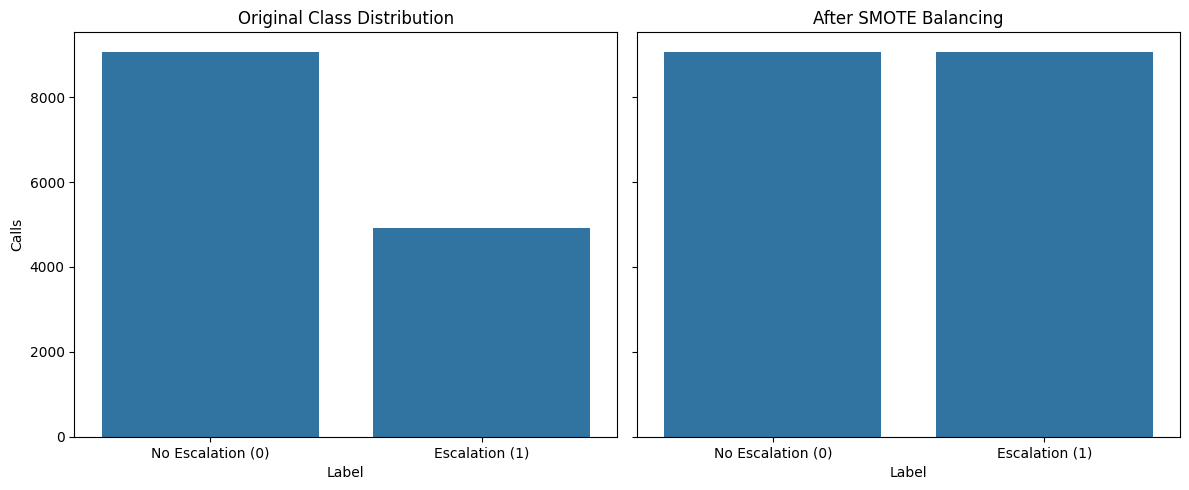

In [14]:
# Plot bar charts of class imbalance before and after resaampling for escalation indicators
def plot_class_distribution(y_train, y_bal=None):
    fig, ax = plt.subplots(1, 2 if y_bal is not None else 1, figsize=(12, 5), sharey=True)

    sns.countplot(x=y_train, ax=ax[0] if y_bal is not None else ax)
    ax[0 if y_bal is not None else 0].set_title("Original Class Distribution")
    ax[0 if y_bal is not None else 0].set_xlabel("Label")
    ax[0 if y_bal is not None else 0].set_ylabel("Calls")
    ax[0 if y_bal is not None else 0].set_xticks([0, 1])
    ax[0 if y_bal is not None else 0].set_xticklabels(["No Escalation (0)", "Escalation (1)"])

    if y_bal is not None:
        sns.countplot(x=y_bal, ax=ax[1])
        ax[1].set_title("After SMOTE Balancing")
        ax[1].set_xlabel("Label")
        ax[1].set_ylabel("Calls")
        ax[1].set_xticks([0, 1])
        ax[1].set_xticklabels(["No Escalation (0)", "Escalation (1)"])

    plt.tight_layout()
    
    plt.savefig('EscalationClassDistribution.png', bbox_inches='tight', dpi=300)

    plt.show()
# Calls function to show plot based on 
# class distribution of non-escalated vs escalated records
# before and after oversampling 
plot_class_distribution(y_train, y_bal)

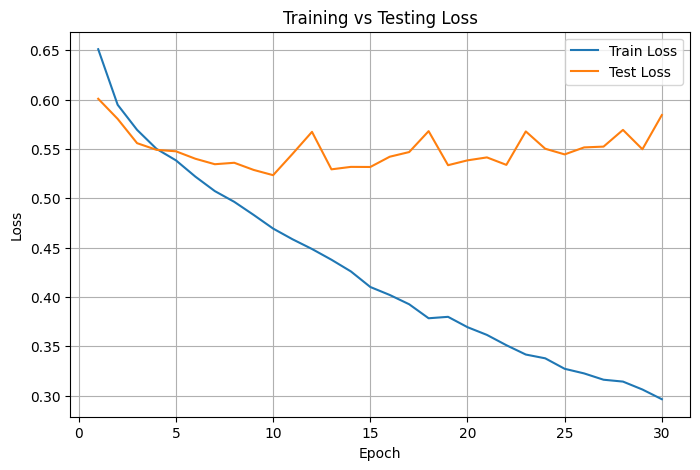

In [15]:
# Function to show how well the model is performing
# on training data versus the testing data with each 
# 'epoch' rotation of predictions 
def plot_skorch_training(net):
    history = net.history
    epochs = [entry['epoch'] for entry in history]
    train_loss = [entry['train_loss'] for entry in history]
    valid_loss = [entry['valid_loss'] for entry in history]

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, valid_loss, label="Test Loss")
    plt.title("Training vs Testing Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    plt.savefig('Train_Test_Loss.png', bbox_inches='tight', dpi=300)
    
    plt.show()

# Calls function to show plot
plot_skorch_training(net)

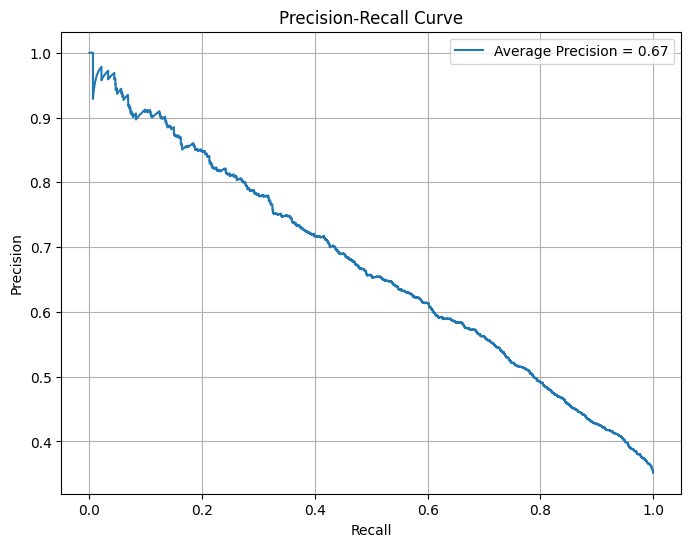

In [16]:
# Plots precision and recall model evaluation metrics
def plot_precision_recall(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"Average Precision = {ap:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.grid(True)

    plt.savefig('PrecisionRecallCurve.png', bbox_inches='tight', dpi=300)

    plt.show()
    
# Runs function 
plot_precision_recall(y_test, y_proba)

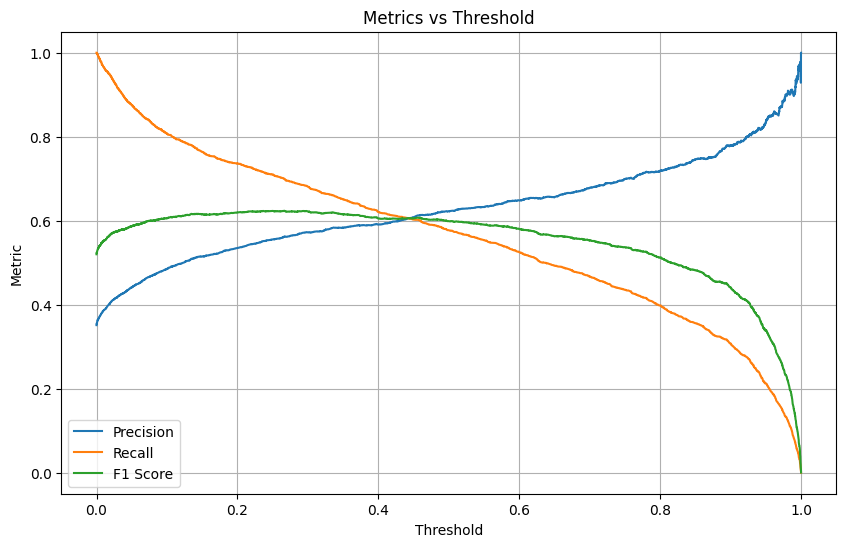

<Figure size 640x480 with 0 Axes>

In [17]:
# Plots model evaluation metrics based on different thresholds used 
def plot_threshold_metrics(y_true, y_scores):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label="Precision")
    plt.plot(thresholds, recall[:-1], label="Recall")
    plt.plot(thresholds, f1_scores[:-1], label="F1 Score")
    plt.xlabel("Threshold")
    plt.ylabel("Metric")
    plt.title("Metrics vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.savefig('EvaluationMetricsVsThresholds.png', bbox_inches='tight', dpi=300)

# Run function to plot F1, precision, and recall of model
plot_threshold_metrics(y_test, y_proba)

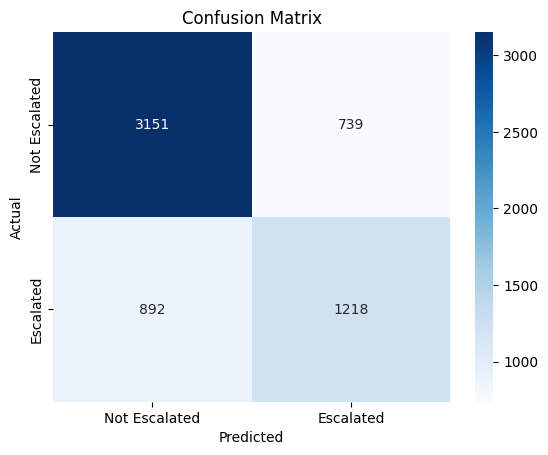

In [18]:
# Plots confusion matrix of actual versus predictions
def plot_confusion(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Not Escalated", "Escalated"],
                yticklabels=["Not Escalated", "Escalated"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    
    plt.savefig('EscalationConfusionMatrix.png')

    plt.show()

# probability to use to determine if escalated prediction should be made
y_pred = (y_proba >= 0.5).astype(int)  
# Runs function to  plot confusion matrix
plot_confusion(y_test, y_pred)

In [19]:
# Plots the estimated cost savings for identifying and routing escalated calls to properly skilled agents
def plot_cost_savings(num_routed=120, cost_per_escalation=50, reduction_per_correct=20):
    total_cost_current = num_routed * cost_per_escalation
    correct_preds = int(num_routed * 0.75)  # assume 75% routing accuracy
    total_cost_predicted = total_cost_current - (correct_preds * reduction_per_correct)

    categories = ['Current Process', 'With Escalation Model']
    costs = [total_cost_current, total_cost_predicted]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(categories, costs, color=['gray', 'green'])
    plt.ylabel("Estimated Cost ($)")
    plt.title("Estimated Cost Savings via Escalation Routing")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 10, f"${int(yval)}", ha='center')
    plt.tight_layout()
    
    plt.savefig('EstimatedCostSavings.png', bbox_inches='tight', dpi=300)

    plt.show()


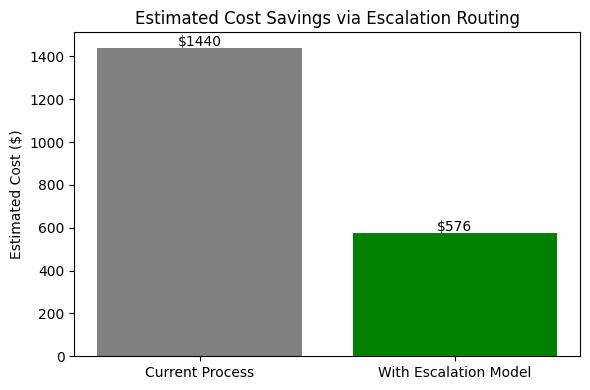

In [20]:
# Runs function to plot cost savings
# Can change cost parameters
plot_cost_savings(cost_per_escalation=12, reduction_per_correct=9.6)

In [21]:
# Plots the distribution of escalation probabilities
def plot_escalation_probability_distribution(y_proba):
    plt.figure(figsize=(7, 4))
    sns.histplot(y_proba, bins=20, kde=True, color='skyblue')
    plt.title("Distribution of Predicted Escalation Probabilities")
    plt.xlabel("Predicted Probability of Escalation")
    plt.ylabel("Number of Calls")
    plt.tight_layout()
    plt.savefig('EscalationProbabilityDistribution.png', bbox_inches='tight', dpi=300)
    plt.show()

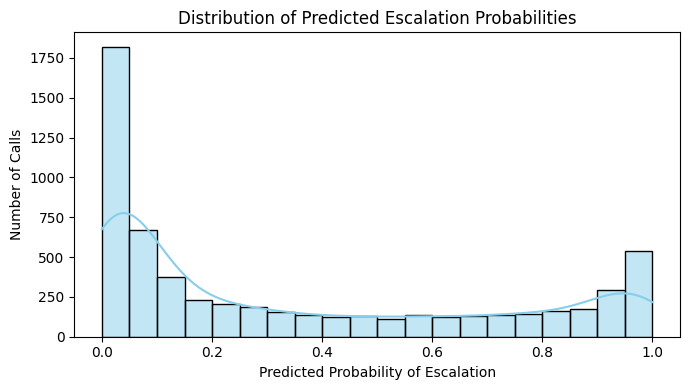

In [22]:
# Runs the function to plot the distribution of the escalation probabilities
plot_escalation_probability_distribution(y_proba)

/opt/anaconda3/envs/clean-ds/lib/python3.10/site-packages/matplotlib/cbook.py:684: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(x, subok=True, copy=copy)


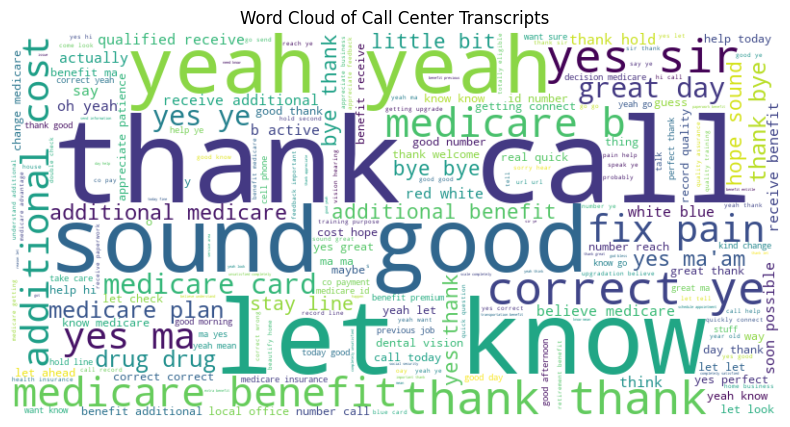

In [23]:
# Displays wordcloud of most used words for non-escalated records (with exclusions)
all_text = " ".join(texts)

# removes [bracketed words]
clean_text = re.sub(r'\[[^\]]+\]', '', all_text)

# removes words containing underscores 
clean_text = re.sub(r'\b\w*_\w*\b', '', clean_text)

# Remove unwanted words
unwanted_words = ['occupation', 'organization', 'personname', 'location', 'person_name', 'product', 'department_name', 'phone_number', 'duration', 'time', 'hello', 'phone number', 'zip code', 'address', 'email address', 'mailing address', 'birth', 'date', 'okay', 'right', 'sound' 'good']
pattern = r'\b(?:' + '|'.join(unwanted_words) + r')\b'
clean_text = re.sub(pattern, '', clean_text, flags=re.IGNORECASE)

# Remove whitespace
clean_text = re.sub(r'\s+', ' ', clean_text).strip()

# Create wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clean_text)

# Plot and save chart
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Call Center Transcripts")

plt.savefig('call_center_wordcloud.png')

plt.show()

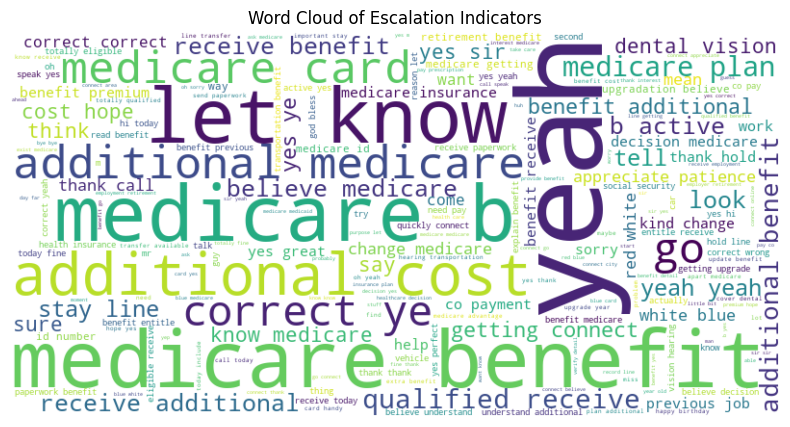

In [24]:
# Displays wordcloud of most used words for Escalated records (with exclusions)
escalated_texts = [text for text, pred in zip(texts, y_pred) if pred == 1] # true escalations
all_text = " ".join(escalated_texts)

# removes [bracketed words]
clean_text = re.sub(r'\[[^\]]+\]', '', all_text)

# removes words containing underscores 
clean_text = re.sub(r'\b\w*_\w*\b', '', clean_text)

# Remove unwanted words
unwanted_words = ['occupation', 'organization', 'personname', 'location', 'person_name', 'product', 'department_name', 'phone_number', 'duration', 'time', 'hello', 'phone number', 'zip code', 'address', 'email address', 'mailing address', 'birth', 'date', 'okay', 'right', 'sound', 'good', 'ma']
pattern = r'\b(?:' + '|'.join(unwanted_words) + r')\b'
clean_text = re.sub(pattern, '', clean_text, flags=re.IGNORECASE)

# Remove whitespace
clean_text = re.sub(r'\s+', ' ', clean_text).strip()


# Create wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(clean_text)

# Plot and save chart
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Escalation Indicators")

plt.savefig('call_center_wordcloud_escalated.png')

plt.show()

In [25]:
# Plots the average predicted probabilites based on percent of actual escalations 
def plot_calibration_curve(y_true, y_proba, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_proba, n_bins=n_bins)

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label="Model")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Perfect Calibration")
    plt.title("Calibration Curve: Confidence vs Actual Escalation Rate")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives (Escalations)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    plt.savefig('actual vs predicted calibration.png', bbox_inches='tight', dpi=300)

    plt.show()


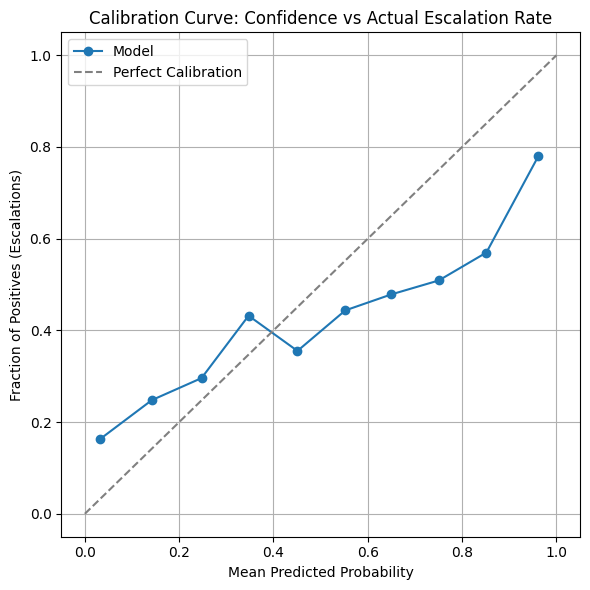

In [26]:
# Run function to plot calibration curve showing effectiveness of model predictions 
plot_calibration_curve(y_test, y_proba)